In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from matplotlib import pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import warnings
import pickle
import json
warnings.filterwarnings("ignore")

Link to the data set: https://www.kaggle.com/datasets/amitabhajoy/bengaluru-house-price-data

# 1. Data Cleaning

In [2]:
df1 = pd.read_csv("Bengaluru_House_Data.csv") # Reading in the file
df1.head() # Showing the first five rows of the df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


Price is the dependent variable. It is represented in Indian Lakh Rupees. $1$ Lakh = $100000$.

For example, in the first row we have $39.07 * 100000$ Rupees. It is around $44493.81$ Euros if converted.

In [3]:
df1.shape # Checking the dimensions

(13320, 9)

Let's examine the features one by one.

In [4]:
for column in df1.columns:
    print(df1.groupby(column)[column].agg('count'))
    print(" ")

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64
 
availability
14-Jul                      1
14-Nov                      1
15-Aug                      1
15-Dec                      1
15-Jun                      1
                        ...  
22-Mar                      3
22-May                     10
22-Nov                      2
Immediate Possession       16
Ready To Move           10581
Name: availability, Length: 81, dtype: int64
 
location
 Anekal                 1
 Banaswadi              1
 Basavangudi            1
 Bhoganhalli            1
 Devarabeesana Halli    6
                       ..
t.c palya               1
tc.palya                4
vinayakanagar           1
white field,kadugodi    1
whitefiled              1
Name: location, Length: 1305, dtype: int64
 
size
1 BHK          538
1 Bedroom      105
1 RK            13
10 BHK           2
10 Bedroom      12
11 BHK      

This model will be a simple one for practice, so I just assume some columns are not important, thus, I will remove them.

In [5]:
df2 = df1.drop(['area_type','availability','society'], axis = 'columns')
df2.head()

,location,size,total_sqft,bath,balcony,price
0,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Kothanur,2 BHK,1200,2.0,1.0,51.00


In [6]:
df2.shape # We had 9 columns, droped 3. Ended up with 6 as expected.

(13320, 6)

Let's check for missing or null values in our data set.

In [7]:
df2.isnull().sum()

location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64

In [8]:
# Displaying the percentage of missing values
(df2.isnull().sum() / df1.shape[0]) * 100

location      0.007508
size          0.120120
total_sqft    0.000000
bath          0.548048
balcony       4.572072
price         0.000000
dtype: float64

Since 'balcony' have $4.6\%$ missing values, we will replace them with the median value. The rest of rows with Nan values are a small percentage of the dataset, so we will drop them.

In [9]:
df2['balcony'] = df2['balcony'].fillna(df2['balcony'].median())

In [10]:
(df2.groupby('balcony')['balcony'].agg('count'))

balcony
0.0    1029
1.0    4897
2.0    5722
3.0    1672
Name: balcony, dtype: int64

Let's check again for missing values.

In [11]:
df2.isnull().sum() 

location       1
size          16
total_sqft     0
bath          73
balcony        0
price          0
dtype: int64

In [12]:
df3 = df2.dropna() # Dropping the rows with NA values.
df3.isnull().sum() # Let's check again.

location      0
size          0
total_sqft    0
bath          0
balcony       0
price         0
dtype: int64

In [13]:
df3.shape

(13246, 6)

Exploring the "size" feature.

In [14]:
df3['size'].unique() # 4 Bedroom and 4 BHK are the same

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

We can see that '4 Bedroom' is the same as '4 BHK' so we have to handle this problem. By creating a new column and inserting the numerical values in it.

Every input has a number in the first place, so we will split and get the first argument [0].

In [15]:
df3['Bedroom'] = df3['size'].apply(lambda x: int( x.split(' ')[0] ))

In [16]:
# Now we can drop the size column since it's numerical values got extracted in
# new column 'Bedroom'
df4 = df3.drop(['size'], axis = 'columns')
df4.head()

,location,total_sqft,bath,balcony,price,Bedroom
0,Electronic City Phase II,1056,2.0,1.0,39.07,2
1,Chikka Tirupathi,2600,5.0,3.0,120.00,4
2,Uttarahalli,1440,2.0,3.0,62.00,3
3,Lingadheeranahalli,1521,3.0,1.0,95.00,3
4,Kothanur,1200,2.0,1.0,51.00,2


In [17]:
numBedrooms = df4['Bedroom'].unique()
numBedrooms.sort()
numBedrooms

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 18, 19,
       27, 43], dtype=int64)

$27$ and $43$ bedrooms are too many. Let's check those apartments.

In [18]:
df4[df4.Bedroom > 20] # Looking for all apartments with greater than 20 Bedroom

,location,total_sqft,bath,balcony,price,Bedroom
1718,2Electronic City Phase II,8000,27.0,0.0,230.0,27
4684,Munnekollal,2400,40.0,0.0,660.0,43


This is a possible error. We can't have a $2400$ sqft apartment with $43$ bedrooms.

But first let's explore the 'total'sqft' feature.

In [19]:
df4.total_sqft.unique() # We have range in sqft. For example '1133 - 1384'

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

There are some values like $'1133 - 1384'$ so we have to solve this problem also.

In [20]:
# Function that will tell us what numbers are float.
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [21]:
df4[~df4['total_sqft'].apply(is_float)].head(10)

,location,total_sqft,bath,balcony,price,Bedroom
30,Yelahanka,2100 - 2850,4.0,0.0,186.000,4
122,Hebbal,3067 - 8156,4.0,0.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,0.0,54.005,2
165,Sarjapur,1145 - 1340,2.0,0.0,43.490,2
188,KR Puram,1015 - 1540,2.0,0.0,56.800,2
410,Kengeri,34.46Sq. Meter,1.0,0.0,18.500,1
549,Hennur Road,1195 - 1440,2.0,0.0,63.770,2
648,Arekere,4125Perch,9.0,2.0,265.000,9
661,Yelahanka,1120 - 1145,2.0,0.0,48.130,2
672,Bettahalsoor,3090 - 5002,4.0,0.0,445.000,4


If we have a range of two numbers, we will take the average. And anytime we have an input, for example $'34.46Sq. Meter'$ we will drop that row. 

To improve the model, for future work write a function that converts sq meters, sq yards into sqft.

In [22]:
# total_sqft have lot of problems
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        # If x is '2100-2850' returns the average 2475.0
        return (float(tokens[0])+float(tokens[1]))/2 
    try:
        return float(x) # If x is '6487' it is converted to float
    except:
        return None

In [23]:
df5 = df4.copy()

In [24]:
df5['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)
df5.head(10)

,location,total_sqft,bath,balcony,price,Bedroom
0,Electronic City Phase II,1056.0,2.0,1.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4
2,Uttarahalli,1440.0,2.0,3.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3
4,Kothanur,1200.0,2.0,1.0,51.00,2
5,Whitefield,1170.0,2.0,1.0,38.00,2
6,Old Airport Road,2732.0,4.0,2.0,204.00,4
7,Rajaji Nagar,3300.0,4.0,2.0,600.00,4
8,Marathahalli,1310.0,3.0,1.0,63.25,3
9,Gandhi Bazar,1020.0,6.0,2.0,370.00,6


# 2. Feature engineering

In real estate, the price / Sqft quantity is important. So we will create that feature because it can be helpful to detect outliers.

In [25]:
df6 = df5.copy()

In [26]:
# The price is expressed in Lack, so we have to multiply it by 10^5.

df6['price_per_sqft'] = df6['price']*100000/df6['total_sqft']
df6.head()

,location,total_sqft,bath,balcony,price,Bedroom,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,1.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,3.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,1.0,51.00,2,4250.000000


In [27]:
len(df6.location.unique()) # We have lot of locations

1304

In [28]:
df6.location = df6.location.apply(lambda x: x.strip())
location_stats = df6.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

Let's say any location which has less then 10 data points is called 'Other' location.

In [29]:
len(location_stats[location_stats <= 10])

1052

In [30]:
location_stats_less_than_10 = location_stats[location_stats <= 10]
location_stats_less_than_10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [31]:
len(df6.location.unique())

1293

In [32]:
df6.location = df6.location.apply(lambda x: 'Other' if x in location_stats_less_than_10 else x)

In [33]:
len(df6.location.unique())

242

In [34]:
df6.head(10)

,location,total_sqft,bath,balcony,price,Bedroom,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,1.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,3.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,1.0,51.00,2,4250.000000
5,Whitefield,1170.0,2.0,1.0,38.00,2,3247.863248
6,Old Airport Road,2732.0,4.0,2.0,204.00,4,7467.057101
7,Rajaji Nagar,3300.0,4.0,2.0,600.00,4,18181.818182
8,Marathahalli,1310.0,3.0,1.0,63.25,3,4828.244275
9,Other,1020.0,6.0,2.0,370.00,6,36274.509804


This way, later on, we will have fewer dimensions when we convert the location column to one hot encoded data.

# 3. Outlier detection

Searching for some unusual data, for example. There is a $600$ sq ft apartment with $6$ bedrooms. I will determine some threshold for filtering these occurrences.

In [35]:
# 300 is threshold for 1 bedroom let say
df6[df6.total_sqft/df6.Bedroom<300].head() 

,location,total_sqft,bath,balcony,price,Bedroom,price_per_sqft
9,Other,1020.0,6.0,2.0,370.0,6,36274.509804
45,HSR Layout,600.0,9.0,2.0,200.0,8,33333.333333
58,Murugeshpalya,1407.0,4.0,1.0,150.0,6,10660.980810
68,Devarachikkanahalli,1350.0,7.0,0.0,85.0,8,6296.296296
70,Other,500.0,3.0,2.0,100.0,3,20000.000000


In the second row, there is an apartment of $600$ sq ft with $8$ bedrooms. That's not possible. So we can safely remove them.

In [36]:
df6.shape

(13246, 7)

In [37]:
df7 = df6[~(df6.total_sqft/df5.Bedroom<300)] # Removed above mentioned outliers
df7.shape

(12502, 7)

Let's check now the price per sq ft. If the price is very low or very high, those can also be an outlier.

In [38]:
df7.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

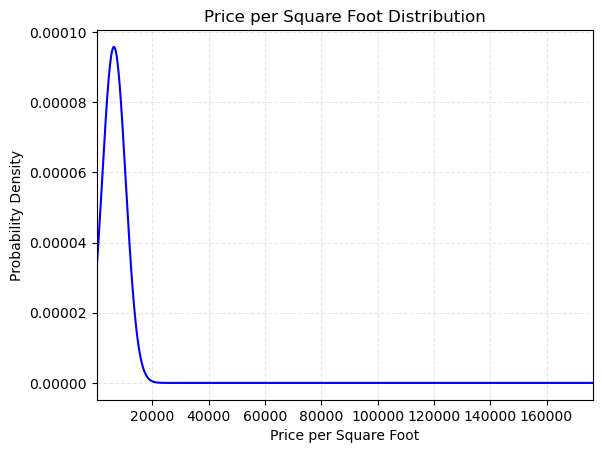

In [39]:
def graph(df7):
    df7_mean = np.mean(df7['price_per_sqft'])
    df7_std = np.std(df7['price_per_sqft'])
    pdf = stats.norm.pdf(df7["price_per_sqft"].sort_values(), df7_mean, df7_std)
    fig, ax = plt.subplots()
    ax.plot(df7["price_per_sqft"].sort_values(), pdf, color='blue')
    ax.set_xlim([np.min(df7['price_per_sqft']),np.max(df7['price_per_sqft'])])
    ax.set_xlabel('Price per Square Foot')
    ax.set_ylabel('Probability Density')
    ax.set_title('Price per Square Foot Distribution')
    ax.grid(True, alpha=0.3, linestyle="--")
    plt.show()

graph(df7)

In [40]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

df8 = remove_pps_outliers(df7)
df8.shape

(10241, 7)

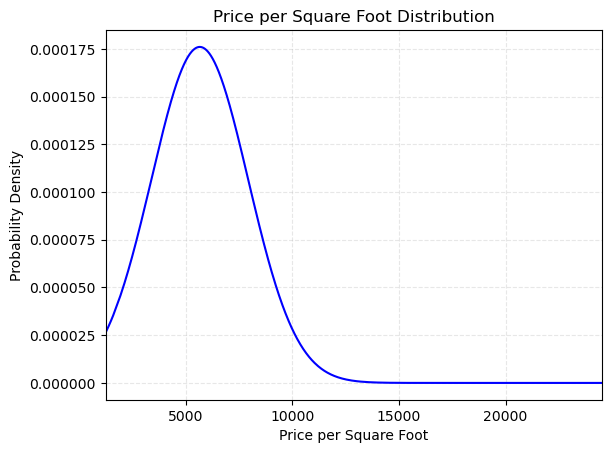

In [41]:
graph(df8)

More filtering can be done. For example, if the price of an apartment with $3$ bedrooms is smaller than an apartment with $2$ bedrooms for the same sq ft.

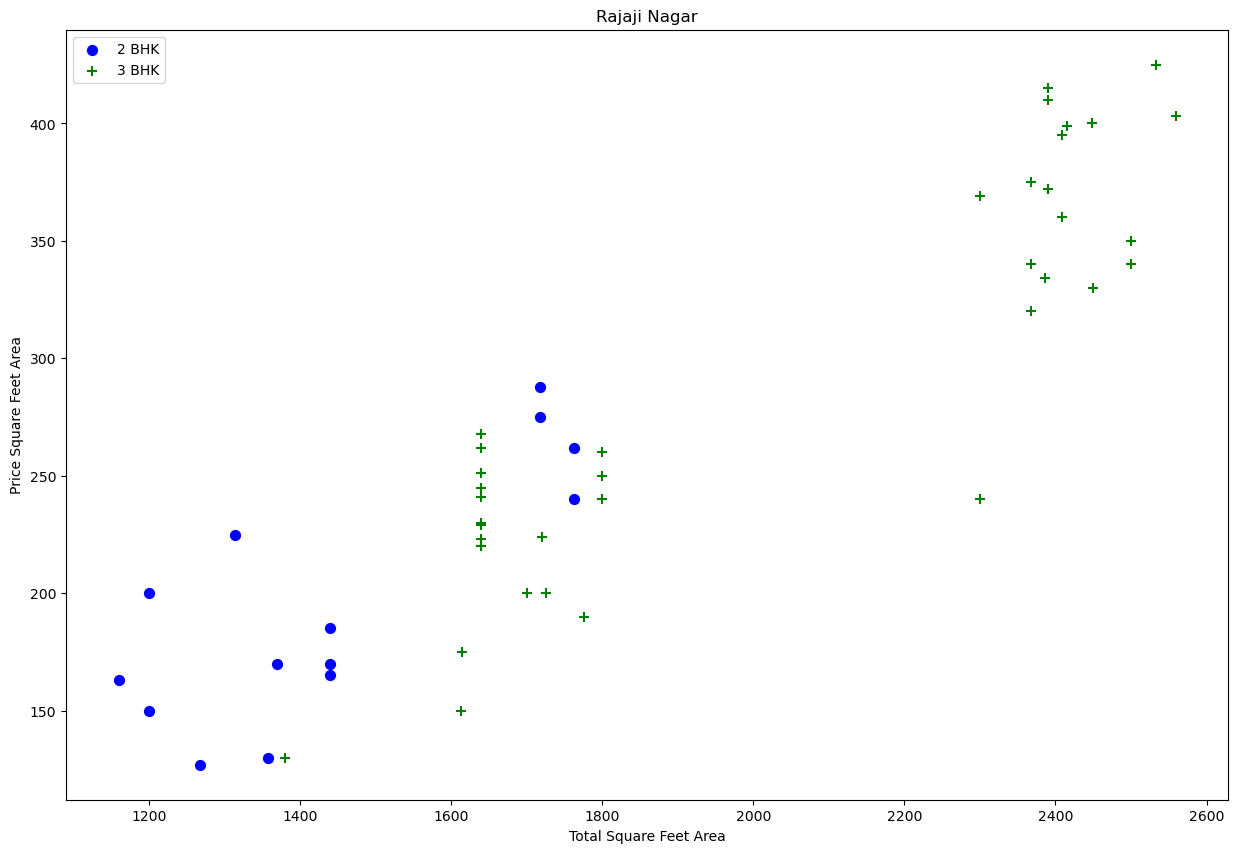

In [42]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location==location) & (df.Bedroom==2)]
    bhk3 = df[(df.location==location) & (df.Bedroom==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='+', color='green', label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price Square Feet Area")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df8,'Rajaji Nagar')

We can see the outliers in the middle.

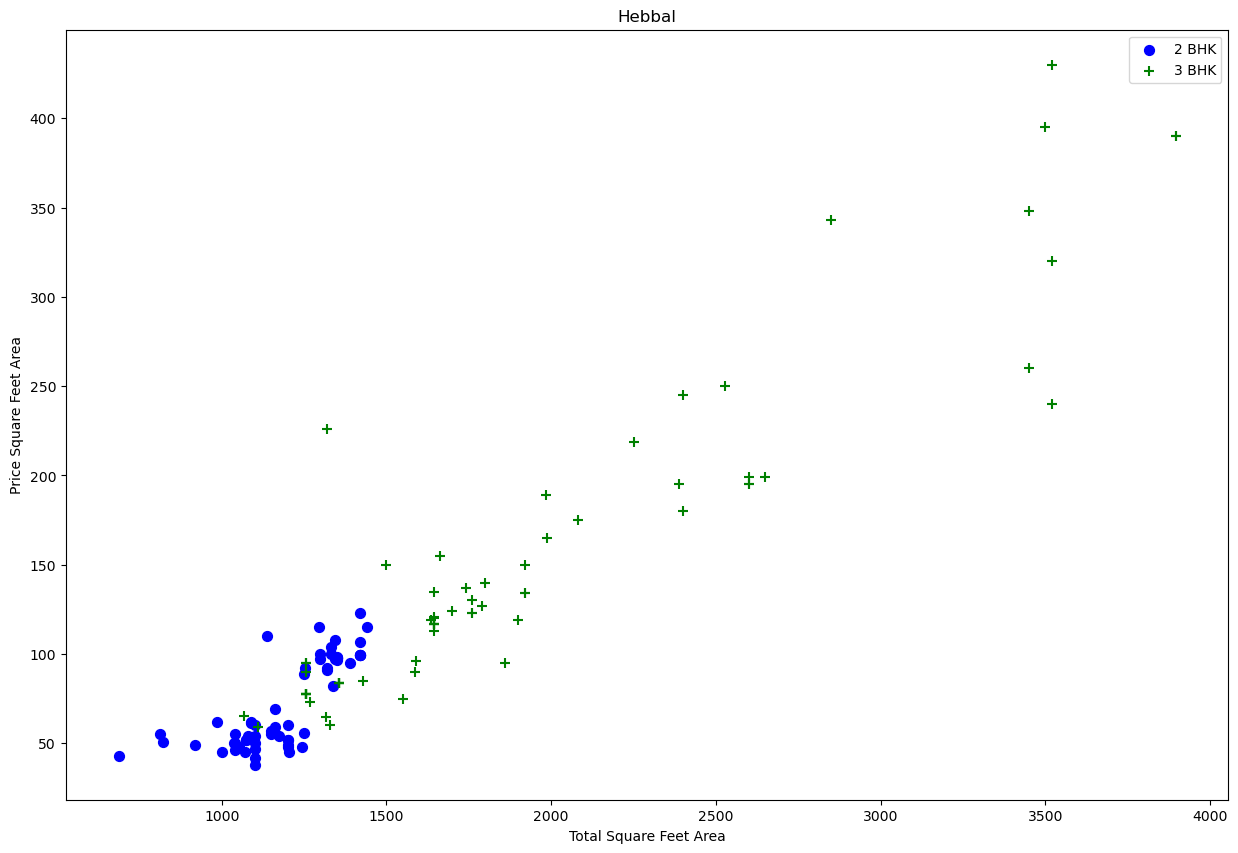

In [43]:
plot_scatter_chart(df7,'Hebbal')

We should also remove properties where for same location, the price of for example 3 bedroom apartment is less than 2 bedroom apartment (with same sqft area). What we will do is for a given location, we will build a dictionary of stats per Bedroom  i.e.,

{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },
}

Now we can remove those 2 bedroom apartments whose price per sqft is less than mean price per sqft of 1 bedroom apartment.

In [44]:
def remove_Bedroom_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        Bedroom_stats = {}
        for Bedroom, Bedroom_df in location_df.groupby('Bedroom'):
            Bedroom_stats[Bedroom] = {
                'mean': np.mean(Bedroom_df.price_per_sqft),
                'std': np.std(Bedroom_df.price_per_sqft),
                'count': Bedroom_df.shape[0]
            }
        for Bedroom, Bedroom_df in location_df.groupby('Bedroom'):
            stats = Bedroom_stats.get(Bedroom-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, Bedroom_df[Bedroom_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

df9 = remove_Bedroom_outliers(df8)
df9.shape

(7329, 7)

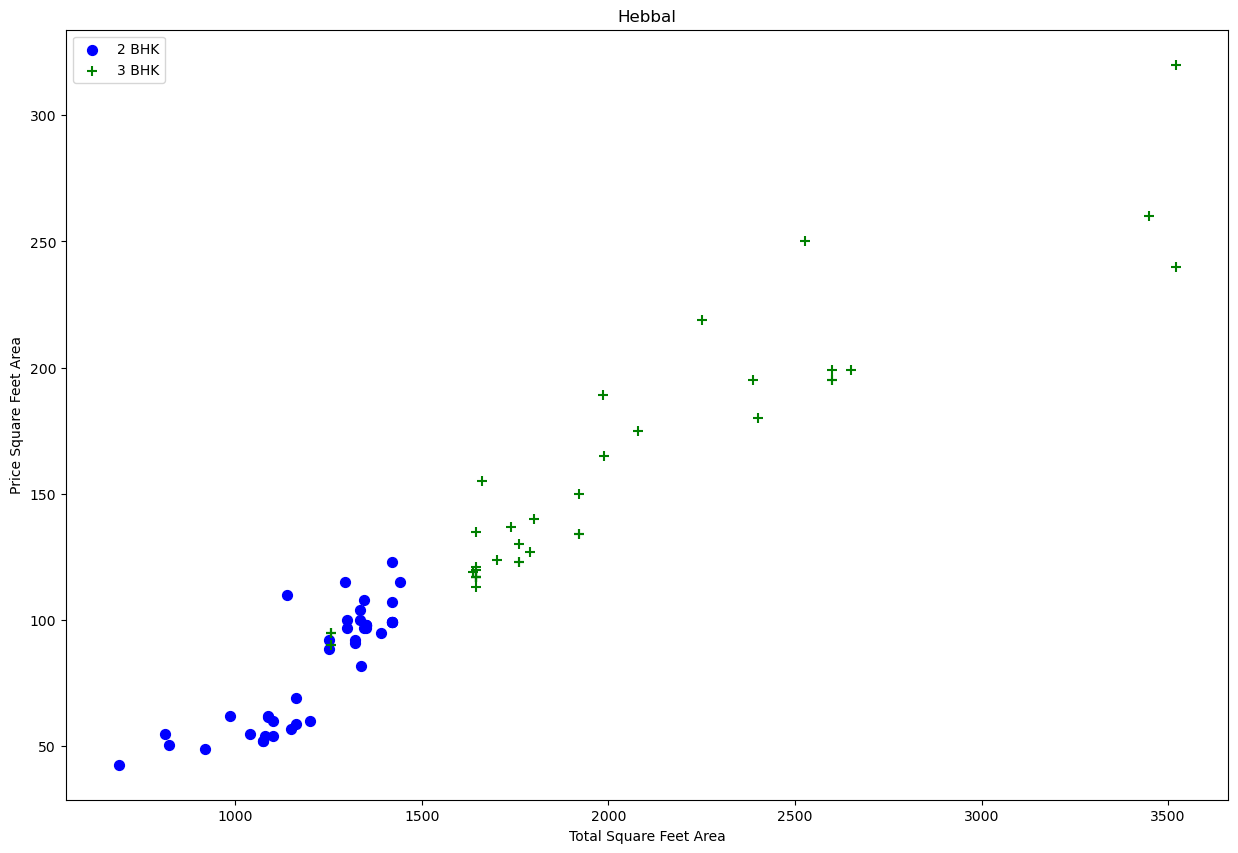

In [45]:
 plot_scatter_chart(df9,'Hebbal')

We can see that a lot of outliers have been removed.

Further more, let's see how many apartments there are per sqft area.

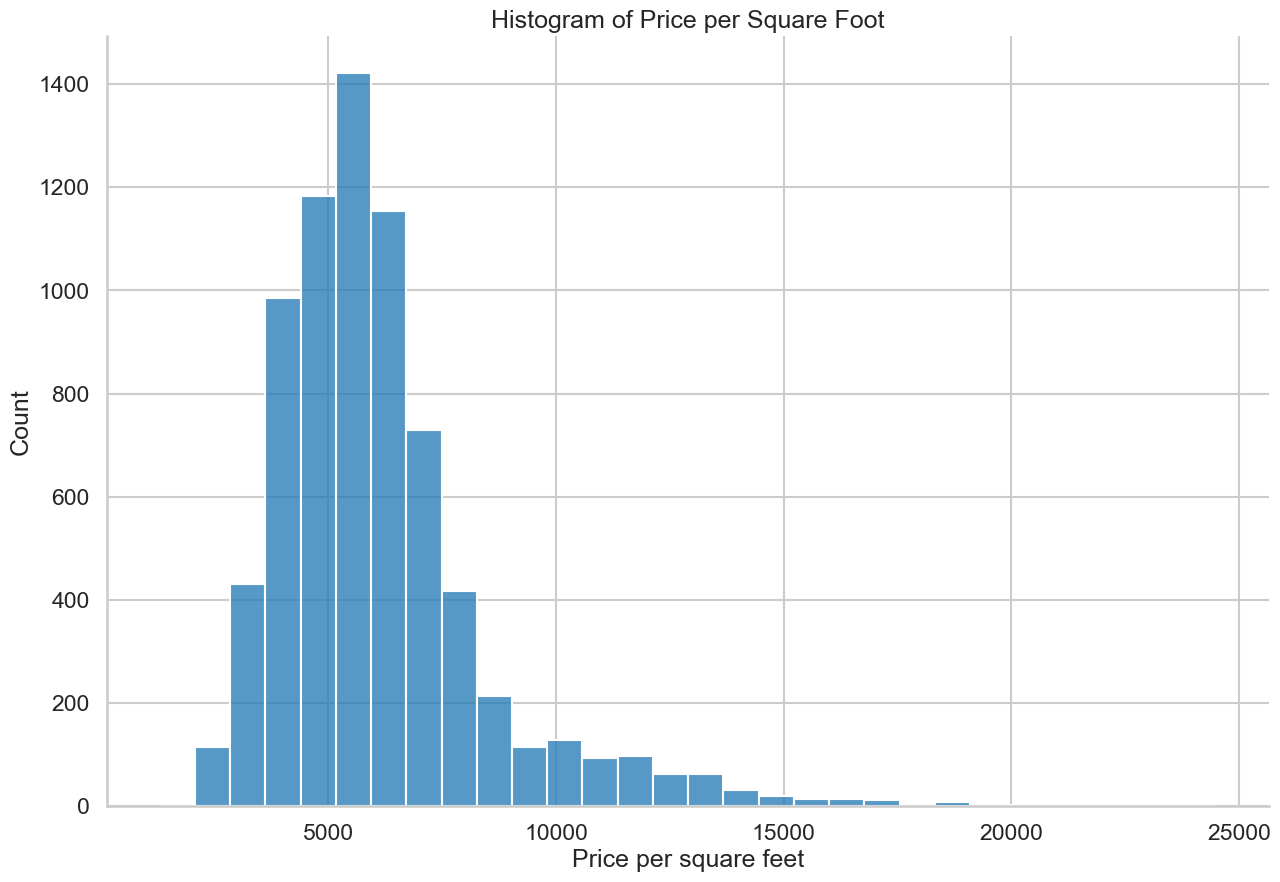

In [46]:
sns.set_style("whitegrid")
sns.set_context("talk")

sns.histplot(df9.price_per_sqft, kde=False, bins=30)
plt.xlabel("Price per square feet")
plt.ylabel("Count")
plt.title("Histogram of Price per Square Foot")
sns.despine()
plt.show()

The data seens normal, having a nice bell curve shape.

What about bathroom, feature 'bath'?

In [47]:
df9.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [48]:
df9[df9.bath>10]

,location,total_sqft,bath,balcony,price,Bedroom,price_per_sqft
5277,Neeladri Nagar,4000.0,12.0,2.0,160.0,10,4000.000000
5925,Other,12000.0,12.0,2.0,525.0,10,4375.000000
6014,Other,10000.0,16.0,2.0,550.0,16,5500.000000
6747,Other,6000.0,12.0,2.0,150.0,11,2500.000000
7078,Other,5425.0,13.0,0.0,275.0,13,5069.124424


Apartments with too many bathrooms are very strange. So we filter further more, but before let's plot a histogram.

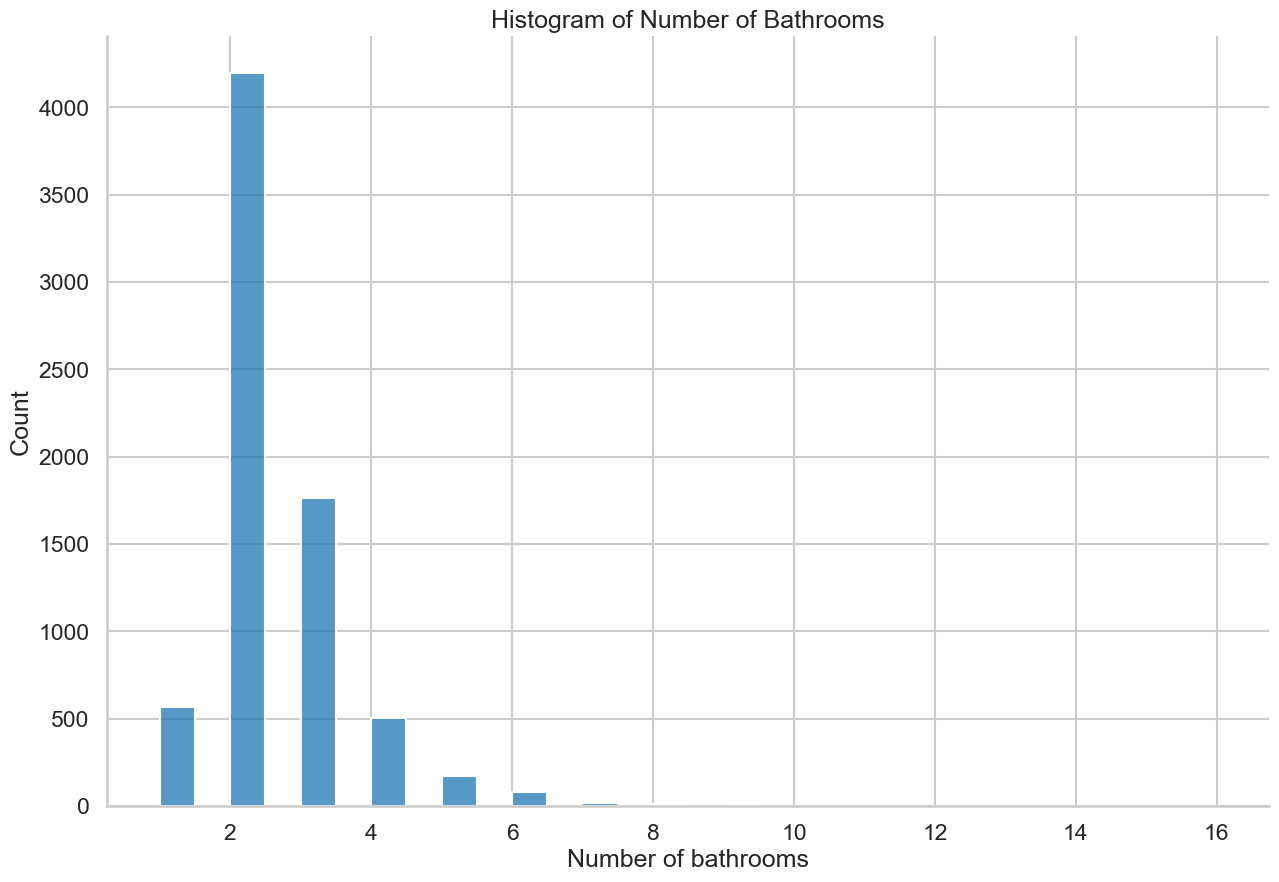

In [49]:
sns.set_style("whitegrid")
sns.set_context("talk")

sns.histplot(df9.bath, kde=False, bins=30)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")
plt.title("Histogram of Number of Bathrooms")
sns.despine()
plt.show()

The majority of apartments have 2 bathrooms. So let's say, we will remove all data where the number of bathrooms is greater than the number of bedrooms + 2.

In [50]:
df9[df9.bath > df9.Bedroom + 2]

,location,total_sqft,bath,balcony,price,Bedroom,price_per_sqft
1626,Chikkabanavar,2460.0,7.0,2.0,80.0,4,3252.032520
5238,Nagasandra,7000.0,8.0,2.0,450.0,4,6428.571429
5850,Other,11338.0,9.0,1.0,1000.0,6,8819.897689
9012,Thanisandra,1806.0,6.0,2.0,116.0,3,6423.034330


In [51]:
df10 = df9[df9.bath < df9.Bedroom + 2]
df10.shape

(7251, 7)

We can drop price_per_sqft because we used it only for outlier detection.

In [52]:
df11 = df10.drop(['price_per_sqft'], axis='columns')
df11.head()

,location,total_sqft,bath,balcony,price,Bedroom
0,1st Block Jayanagar,2850.0,4.0,1.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,2.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,3.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,0.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,2.0,148.0,2


# 4. Final preparations - One Hot Encoding

Since machine learning algorithms can't interpret text data, we have to use one hot encoding on location feature.  For each location it will create a new column.

In [53]:
dummies = pd.get_dummies(df11.location)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we just add the dummies data frame to our data frame with concatenation.

In [54]:
df12 = pd.concat([df11,dummies.drop('Other',axis='columns')],axis='columns')
df12.head()

,location,total_sqft,bath,balcony,price,Bedroom,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,1.0,428.0,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,2.0,194.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,3.0,235.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,0.0,130.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,2.0,148.0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And since the concatination happend, we don't need anymore the 'location' feature.

In [55]:
df13 = df12.drop('location', axis='columns')
df13.head()

,total_sqft,bath,balcony,price,Bedroom,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,1.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,2.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,0.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 5. The ML model

In [56]:
df13.shape

(7251, 246)

Droping the 'price' feature, because that's the value we want to predict. Creating data frame X for training.

In [57]:
X = df13.drop('price', axis = 'columns')
X.head()

,total_sqft,bath,balcony,Bedroom,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,1.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,2.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,0.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
y = df13.price
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

Dividing the data into $80\%$ train and $20\%$ test.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 10)

In [60]:
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.8691427729130289

To potentially improve a model we use k-fold cross validation.

In [61]:
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)

cross_val_score(LinearRegression(), X, y, cv = cv)

array([0.85433917, 0.84180316, 0.84736132, 0.85178706, 0.87170425])

How about to try other models? In that order Grid Search CV can help us.

In [62]:
def find_best_model_using_gridSearchCV(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score = False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns = ['model','best_score','best_params'])

In [63]:
find_best_model_using_gridSearchCV(X,y)

,model,best_score,best_params
0,linear_regression,0.853399,{'normalize': True}
1,lasso,0.727567,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.725533,"{'criterion': 'mse', 'splitter': 'random'}"


Linear regression, still have the best performane. So we will pick it.

In [64]:
X.columns

Index(['total_sqft', 'bath', 'balcony', 'Bedroom', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=245)

In [65]:
np.where(X.columns == '2nd Phase Judicial Layout')[0][0]

6

In [66]:
def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(X.columns == location)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
    return lr_clf.predict([x])[0]

In [67]:
predict_price('1st Phase JP Nagar', 1000, 2, 2)

88.76090859865617

In [68]:
predict_price('1st Phase JP Nagar', 500, 2, 2)

45.2355141819356

In [69]:
predict_price('Indira Nagar', 500, 2, 2)

141.77545639689438

In [70]:
predict_price('Indira Nagar', 500, 1, 3)

139.56791659942024

Export the model to pickle file and creating json file

In [71]:
with open('banglore_home_prices_model.pickle', 'wb') as f:
    pickle.dump(lr_clf, f)

In [72]:
columns = {
    'data_columns': [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))